# Train LSTM model to Enduro sequence games

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *
import matplotlib.pyplot as plt
import time

## Set to GPU if available

In [2]:
use_gpu = input("Use GPU (y/n) ")
if use_gpu == 'y':
    use_gpu = True
else:
    use_gpu = False
    
device = conf_cuda(use_gpu)

Use GPU (y/n) y
GPU is available


In [3]:
if use_gpu:
    torch.cuda.empty_cache()

## Set configurations

In [7]:
obs = 'softmax'
if obs == 'zigzag':
    zigzag = True
else:
    zigzag = False
zigzag

False

In [8]:
data_path = r"../1-generate/data/"
n_epochs = 10000
hidden_neurons = 200
stop_train = 1e-5

start_match = 45
end_match = 45

start_frame = 1
end_frame = 1000

is_softmax = True

In [9]:
model_name = f"{obs}_m{start_match}to{end_match}_f{start_frame}to{end_frame}_epoch{n_epochs}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name + " created")
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/softmax_m45to45_f1to1000_epoch10000_H200
ATTENTION! folder not created. Training informations will overwrite the existing one


## Load frames and targets

In [10]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)
ACTIONS_LIST

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
num_of_frames_arr = []
frames_arr = []
actions_arr = []

for m in range(start_match, end_match + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

Successfully loaded NPZ.


In [12]:
data = np.array(frames_arr)/255
targets = np.array(actions_arr)
num_of_frames_arr = np.array(num_of_frames_arr)

In [13]:
data = torch.tensor(data).float()
targets = torch.tensor(targets).float()

## Create model

In [14]:
model = Model(device=device, input_size=20400, output_size=len(ACTIONS_LIST), hidden_dim=hidden_neurons, n_layers=1, is_softmax=is_softmax)

In [15]:
# We'll also set the model to the device that we defined earlier (default is CPU)
if use_gpu:
    model.cuda()
    data = data.cuda() 
    targets = targets.cuda()

In [16]:
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())

## Model train

In [17]:
train_loss_arr = np.array([])
train_acc_arr = np.array([])
valid_idx_arr = np.array([])
valid_loss_arr = np.array([])
valid_acc_arr = np.array([])

In [20]:
all_idx = np.arange(len(data))
start_time_processing = time.time()

# Training Run
loss_file = open(newpath + '/' + "loss_file.txt", "w")
first_time = True

best_loss = 1
first_epoch = True

for epoch in range(1, n_epochs + 1):
    
    for valid_idx in range(len(data)):

        if len(data) > 1:
            train_idx = np.setdiff1d(all_idx, valid_idx)
            X_train = data[train_idx]
            Y_train = targets[train_idx]
            X_valid = data[valid_idx]
            Y_valid = targets[valid_idx]
        else:
            X_train = data[valid_idx]
            Y_train = targets[valid_idx]

        model.train()

        optimizer.zero_grad() # Clears existing gradients from previous epoch
        X_train.to(device)
        output, hidden = model(X_train.reshape(1, X_train.shape[0], X_train.shape[1]))
        loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        
        if epoch%10 == 0:
            
            train_loss_arr = np.append(train_loss_arr, loss.item())
            train_acc_arr  = np.append(train_acc_arr, get_acc(output, Y_train.reshape(-1, len(ACTIONS_LIST))))

            model.eval()
            
            if len(data) > 1:
                output, hidden = model(X_valid.reshape(1, X_valid.shape[0], X_valid.shape[1]))
                loss = criterion(output, Y_valid.view(-1, len(ACTIONS_LIST)).float())
            
            valid_idx_arr = np.append(valid_idx_arr, int(valid_idx))
            valid_loss_arr = np.append(valid_loss_arr, loss.item())
            if len(data) > 1:
                valid_acc_arr = np.append(valid_acc_arr, get_acc(output, Y_valid.reshape(-1, len(ACTIONS_LIST))))
            
            loss_file.write("Epoch: {}/{} - valid: {}---------------------------------\n".format(epoch, n_epochs, int(valid_idx_arr[-1])))
            loss_file.write("Train -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss_arr[-1], train_acc_arr[-1]))
            if len(data) > 1:
                loss_file.write("Valid -> Loss: {:.15f} Acc: {:.15f}\n".format(valid_loss_arr[-1], valid_acc_arr[-1]))

            print("Epoch: {}/{} - valid: {}---------------------------------".format(epoch, n_epochs, int(valid_idx_arr[-1])))
            print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss_arr[-1], train_acc_arr[-1]))
            if len(data) > 1:    
                print("Valid -> Loss: {:.15f} Acc: {:.15f}".format(valid_loss_arr[-1], valid_acc_arr[-1]))

            if train_loss_arr[-1] < best_loss:
                state = { 'epoch': epoch + 1, 'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(), 'losslogger': train_loss_arr[-1], }
                torch.save(state, newpath + '/' + model_name)
                best_loss = train_loss_arr[-1] 
            else:
                print("model not saved")

loss_file.write("--- %s seconds ---" % (time.time() - start_time_processing))
loss_file.close()
np.savez(newpath + '/' + "train_loss_arr", train_loss_arr)
np.savez(newpath + '/' + "valid_loss_table", valid_loss_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

Epoch: 10/10000 - valid: 0---------------------------------
Train -> Loss: 0.072722673416138 Acc: 0.489000022411346
Epoch: 20/10000 - valid: 0---------------------------------
Train -> Loss: 0.071452163159847 Acc: 0.489000022411346
Epoch: 30/10000 - valid: 0---------------------------------
Train -> Loss: 0.069965548813343 Acc: 0.563000023365021
Epoch: 40/10000 - valid: 0---------------------------------
Train -> Loss: 0.068373821675777 Acc: 0.584000051021576
Epoch: 50/10000 - valid: 0---------------------------------
Train -> Loss: 0.066709153354168 Acc: 0.602000057697296
Epoch: 60/10000 - valid: 0---------------------------------
Train -> Loss: 0.065116167068481 Acc: 0.612000048160553
Epoch: 70/10000 - valid: 0---------------------------------
Train -> Loss: 0.062979020178318 Acc: 0.628000020980835
Epoch: 80/10000 - valid: 0---------------------------------
Train -> Loss: 0.061096198856831 Acc: 0.638000011444092
Epoch: 90/10000 - valid: 0---------------------------------
Train -> Los

Epoch: 710/10000 - valid: 0---------------------------------
Train -> Loss: 0.016637813299894 Acc: 0.920000016689301
Epoch: 720/10000 - valid: 0---------------------------------
Train -> Loss: 0.016196167096496 Acc: 0.921000063419342
Epoch: 730/10000 - valid: 0---------------------------------
Train -> Loss: 0.016031036153436 Acc: 0.922000050544739
Epoch: 740/10000 - valid: 0---------------------------------
Train -> Loss: 0.015328238718212 Acc: 0.929000020027161
Epoch: 750/10000 - valid: 0---------------------------------
Train -> Loss: 0.014847543090582 Acc: 0.938000023365021
Epoch: 760/10000 - valid: 0---------------------------------
Train -> Loss: 0.014301126822829 Acc: 0.941000044345856
Epoch: 770/10000 - valid: 0---------------------------------
Train -> Loss: 0.013757558539510 Acc: 0.948000073432922
Epoch: 780/10000 - valid: 0---------------------------------
Train -> Loss: 0.013295412063599 Acc: 0.950000047683716
Epoch: 790/10000 - valid: 0---------------------------------
Tra

Epoch: 1410/10000 - valid: 0---------------------------------
Train -> Loss: 0.005091951228678 Acc: 0.970000028610229
Epoch: 1420/10000 - valid: 0---------------------------------
Train -> Loss: 0.005061999894679 Acc: 0.970000028610229
Epoch: 1430/10000 - valid: 0---------------------------------
Train -> Loss: 0.005033453926444 Acc: 0.970000028610229
Epoch: 1440/10000 - valid: 0---------------------------------
Train -> Loss: 0.005006098654121 Acc: 0.970000028610229
Epoch: 1450/10000 - valid: 0---------------------------------
Train -> Loss: 0.004979779478163 Acc: 0.970000028610229
Epoch: 1460/10000 - valid: 0---------------------------------
Train -> Loss: 0.004954372067004 Acc: 0.970000028610229
Epoch: 1470/10000 - valid: 0---------------------------------
Train -> Loss: 0.004929766058922 Acc: 0.970000028610229
Epoch: 1480/10000 - valid: 0---------------------------------
Train -> Loss: 0.004905863199383 Acc: 0.970000028610229
Epoch: 1490/10000 - valid: 0----------------------------

Epoch: 2110/10000 - valid: 0---------------------------------
Train -> Loss: 0.004043840337545 Acc: 0.972000062465668
Epoch: 2120/10000 - valid: 0---------------------------------
Train -> Loss: 0.004037478938699 Acc: 0.972000062465668
Epoch: 2130/10000 - valid: 0---------------------------------
Train -> Loss: 0.004031117074192 Acc: 0.972000062465668
Epoch: 2140/10000 - valid: 0---------------------------------
Train -> Loss: 0.004027577582747 Acc: 0.972000062465668
Epoch: 2150/10000 - valid: 0---------------------------------
Train -> Loss: 0.004020123742521 Acc: 0.972000062465668
Epoch: 2160/10000 - valid: 0---------------------------------
Train -> Loss: 0.004012698773295 Acc: 0.972000062465668
Epoch: 2170/10000 - valid: 0---------------------------------
Train -> Loss: 0.004005867056549 Acc: 0.972000062465668
Epoch: 2180/10000 - valid: 0---------------------------------
Train -> Loss: 0.003999221138656 Acc: 0.972000062465668
Epoch: 2190/10000 - valid: 0----------------------------

Epoch: 2760/10000 - valid: 0---------------------------------
Train -> Loss: 0.075097717344761 Acc: 0.489000022411346
model not saved
Epoch: 2770/10000 - valid: 0---------------------------------
Train -> Loss: 0.075096651911736 Acc: 0.489000022411346
model not saved
Epoch: 2780/10000 - valid: 0---------------------------------
Train -> Loss: 0.075094111263752 Acc: 0.489000022411346
model not saved
Epoch: 2790/10000 - valid: 0---------------------------------
Train -> Loss: 0.075092718005180 Acc: 0.489000022411346
model not saved
Epoch: 2800/10000 - valid: 0---------------------------------
Train -> Loss: 0.075095757842064 Acc: 0.489000022411346
model not saved
Epoch: 2810/10000 - valid: 0---------------------------------
Train -> Loss: 0.075094148516655 Acc: 0.489000022411346
model not saved
Epoch: 2820/10000 - valid: 0---------------------------------
Train -> Loss: 0.075092598795891 Acc: 0.489000022411346
model not saved
Epoch: 2830/10000 - valid: 0---------------------------------


Epoch: 3380/10000 - valid: 0---------------------------------
Train -> Loss: 0.075092151761055 Acc: 0.489000022411346
model not saved
Epoch: 3390/10000 - valid: 0---------------------------------
Train -> Loss: 0.075092040002346 Acc: 0.489000022411346
model not saved
Epoch: 3400/10000 - valid: 0---------------------------------
Train -> Loss: 0.075108580291271 Acc: 0.489000022411346
model not saved
Epoch: 3410/10000 - valid: 0---------------------------------
Train -> Loss: 0.075101979076862 Acc: 0.489000022411346
model not saved
Epoch: 3420/10000 - valid: 0---------------------------------
Train -> Loss: 0.075096078217030 Acc: 0.489000022411346
model not saved
Epoch: 3430/10000 - valid: 0---------------------------------
Train -> Loss: 0.075092568993568 Acc: 0.489000022411346
model not saved
Epoch: 3440/10000 - valid: 0---------------------------------
Train -> Loss: 0.075095675885677 Acc: 0.489000022411346
model not saved
Epoch: 3450/10000 - valid: 0---------------------------------


Epoch: 4000/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089909136295 Acc: 0.489000022411346
model not saved
Epoch: 4010/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089901685715 Acc: 0.489000022411346
model not saved
Epoch: 4020/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089901685715 Acc: 0.489000022411346
model not saved
Epoch: 4030/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089894235134 Acc: 0.489000022411346
model not saved
Epoch: 4040/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089879333973 Acc: 0.489000022411346
model not saved
Epoch: 4050/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089871883392 Acc: 0.489000022411346
model not saved
Epoch: 4060/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089864432812 Acc: 0.489000022411346
model not saved
Epoch: 4070/10000 - valid: 0---------------------------------


Epoch: 4620/10000 - valid: 0---------------------------------
Train -> Loss: 0.075091995298862 Acc: 0.489000022411346
model not saved
Epoch: 4630/10000 - valid: 0---------------------------------
Train -> Loss: 0.075091309845448 Acc: 0.489000022411346
model not saved
Epoch: 4640/10000 - valid: 0---------------------------------
Train -> Loss: 0.075090140104294 Acc: 0.489000022411346
model not saved
Epoch: 4650/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089938938618 Acc: 0.489000022411346
model not saved
Epoch: 4660/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089871883392 Acc: 0.489000022411346
model not saved
Epoch: 4670/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089789927006 Acc: 0.489000022411346
model not saved
Epoch: 4680/10000 - valid: 0---------------------------------
Train -> Loss: 0.075089752674103 Acc: 0.489000022411346
model not saved
Epoch: 4690/10000 - valid: 0---------------------------------


Epoch: 5240/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088314712048 Acc: 0.489000022411346
model not saved
Epoch: 5250/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088299810886 Acc: 0.489000022411346
model not saved
Epoch: 5260/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088284909725 Acc: 0.489000022411346
model not saved
Epoch: 5270/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088270008564 Acc: 0.489000022411346
model not saved
Epoch: 5280/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088247656822 Acc: 0.489000022411346
model not saved
Epoch: 5290/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088240206242 Acc: 0.489000022411346
model not saved
Epoch: 5300/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088217854500 Acc: 0.489000022411346
model not saved
Epoch: 5310/10000 - valid: 0---------------------------------


Epoch: 5860/10000 - valid: 0---------------------------------
Train -> Loss: 0.075087159872055 Acc: 0.489000022411346
model not saved
Epoch: 5870/10000 - valid: 0---------------------------------
Train -> Loss: 0.075087130069733 Acc: 0.489000022411346
model not saved
Epoch: 5880/10000 - valid: 0---------------------------------
Train -> Loss: 0.075087107717991 Acc: 0.489000022411346
model not saved
Epoch: 5890/10000 - valid: 0---------------------------------
Train -> Loss: 0.075087085366249 Acc: 0.489000022411346
model not saved
Epoch: 5900/10000 - valid: 0---------------------------------
Train -> Loss: 0.075087063014507 Acc: 0.489000022411346
model not saved
Epoch: 5910/10000 - valid: 0---------------------------------
Train -> Loss: 0.075087040662766 Acc: 0.489000022411346
model not saved
Epoch: 5920/10000 - valid: 0---------------------------------
Train -> Loss: 0.075087025761604 Acc: 0.489000022411346
model not saved
Epoch: 5930/10000 - valid: 0---------------------------------


Epoch: 6480/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088486075401 Acc: 0.489000022411346
model not saved
Epoch: 6490/10000 - valid: 0---------------------------------
Train -> Loss: 0.075091592967510 Acc: 0.489000022411346
model not saved
Epoch: 6500/10000 - valid: 0---------------------------------
Train -> Loss: 0.075088731944561 Acc: 0.489000022411346
model not saved
Epoch: 6510/10000 - valid: 0---------------------------------
Train -> Loss: 0.075086161494255 Acc: 0.489000022411346
model not saved
Epoch: 6520/10000 - valid: 0---------------------------------
Train -> Loss: 0.075085513293743 Acc: 0.489000022411346
model not saved
Epoch: 6530/10000 - valid: 0---------------------------------
Train -> Loss: 0.075085505843163 Acc: 0.489000022411346
model not saved
Epoch: 6540/10000 - valid: 0---------------------------------
Train -> Loss: 0.075085476040840 Acc: 0.489000022411346
model not saved
Epoch: 6550/10000 - valid: 0---------------------------------


Epoch: 7100/10000 - valid: 0---------------------------------
Train -> Loss: 0.075084991753101 Acc: 0.489000022411346
model not saved
Epoch: 7110/10000 - valid: 0---------------------------------
Train -> Loss: 0.075083836913109 Acc: 0.489000022411346
model not saved
Epoch: 7120/10000 - valid: 0---------------------------------
Train -> Loss: 0.075084015727043 Acc: 0.489000022411346
model not saved
Epoch: 7130/10000 - valid: 0---------------------------------
Train -> Loss: 0.075083836913109 Acc: 0.489000022411346
model not saved
Epoch: 7140/10000 - valid: 0---------------------------------
Train -> Loss: 0.075083740055561 Acc: 0.489000022411346
model not saved
Epoch: 7150/10000 - valid: 0---------------------------------
Train -> Loss: 0.075083717703819 Acc: 0.489000022411346
model not saved
Epoch: 7160/10000 - valid: 0---------------------------------
Train -> Loss: 0.075083702802658 Acc: 0.489000022411346
model not saved
Epoch: 7170/10000 - valid: 0---------------------------------


Epoch: 7720/10000 - valid: 0---------------------------------
Train -> Loss: 0.075082018971443 Acc: 0.489000022411346
model not saved
Epoch: 7730/10000 - valid: 0---------------------------------
Train -> Loss: 0.075081974267960 Acc: 0.489000022411346
model not saved
Epoch: 7740/10000 - valid: 0---------------------------------
Train -> Loss: 0.075081951916218 Acc: 0.489000022411346
model not saved
Epoch: 7750/10000 - valid: 0---------------------------------
Train -> Loss: 0.075081914663315 Acc: 0.489000022411346
model not saved
Epoch: 7760/10000 - valid: 0---------------------------------
Train -> Loss: 0.075081884860992 Acc: 0.489000022411346
model not saved
Epoch: 7770/10000 - valid: 0---------------------------------
Train -> Loss: 0.075081840157509 Acc: 0.489000022411346
model not saved
Epoch: 7780/10000 - valid: 0---------------------------------
Train -> Loss: 0.075081817805767 Acc: 0.489000022411346
model not saved
Epoch: 7790/10000 - valid: 0---------------------------------


Epoch: 8340/10000 - valid: 0---------------------------------
Train -> Loss: 0.075079590082169 Acc: 0.489000022411346
model not saved
Epoch: 8350/10000 - valid: 0---------------------------------
Train -> Loss: 0.075079545378685 Acc: 0.489000022411346
model not saved
Epoch: 8360/10000 - valid: 0---------------------------------
Train -> Loss: 0.075079493224621 Acc: 0.489000022411346
model not saved
Epoch: 8370/10000 - valid: 0---------------------------------
Train -> Loss: 0.075079455971718 Acc: 0.489000022411346
model not saved
Epoch: 8380/10000 - valid: 0---------------------------------
Train -> Loss: 0.075079403817654 Acc: 0.489000022411346
model not saved
Epoch: 8390/10000 - valid: 0---------------------------------
Train -> Loss: 0.075079359114170 Acc: 0.489000022411346
model not saved
Epoch: 8400/10000 - valid: 0---------------------------------
Train -> Loss: 0.075079314410686 Acc: 0.489000022411346
model not saved
Epoch: 8410/10000 - valid: 0---------------------------------


Epoch: 8960/10000 - valid: 0---------------------------------
Train -> Loss: 0.075076386332512 Acc: 0.489000022411346
model not saved
Epoch: 8970/10000 - valid: 0---------------------------------
Train -> Loss: 0.075076334178448 Acc: 0.489000022411346
model not saved
Epoch: 8980/10000 - valid: 0---------------------------------
Train -> Loss: 0.075076267123222 Acc: 0.489000022411346
model not saved
Epoch: 8990/10000 - valid: 0---------------------------------
Train -> Loss: 0.075076214969158 Acc: 0.489000022411346
model not saved
Epoch: 9000/10000 - valid: 0---------------------------------
Train -> Loss: 0.075076162815094 Acc: 0.489000022411346
model not saved
Epoch: 9010/10000 - valid: 0---------------------------------
Train -> Loss: 0.075076095759869 Acc: 0.489000022411346
model not saved
Epoch: 9020/10000 - valid: 0---------------------------------
Train -> Loss: 0.075076036155224 Acc: 0.489000022411346
model not saved
Epoch: 9030/10000 - valid: 0---------------------------------


Epoch: 9580/10000 - valid: 0---------------------------------
Train -> Loss: 0.075072266161442 Acc: 0.489000022411346
model not saved
Epoch: 9590/10000 - valid: 0---------------------------------
Train -> Loss: 0.075072191655636 Acc: 0.489000022411346
model not saved
Epoch: 9600/10000 - valid: 0---------------------------------
Train -> Loss: 0.075072117149830 Acc: 0.489000022411346
model not saved
Epoch: 9610/10000 - valid: 0---------------------------------
Train -> Loss: 0.075072050094604 Acc: 0.489000022411346
model not saved
Epoch: 9620/10000 - valid: 0---------------------------------
Train -> Loss: 0.075071968138218 Acc: 0.489000022411346
model not saved
Epoch: 9630/10000 - valid: 0---------------------------------
Train -> Loss: 0.075071901082993 Acc: 0.489000022411346
model not saved
Epoch: 9640/10000 - valid: 0---------------------------------
Train -> Loss: 0.075071811676025 Acc: 0.489000022411346
model not saved
Epoch: 9650/10000 - valid: 0---------------------------------


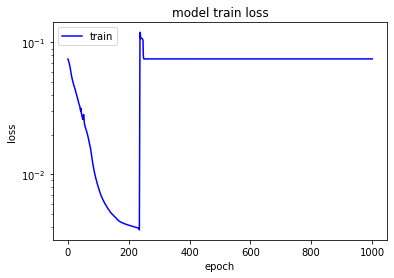

In [21]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.clf()
plt.plot(train_loss_arr, color='blue')
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'train_loss.png')

In [27]:
valid_loss_arr

array([0.07806029, 0.07888003, 0.07552649, 0.07706559, 0.07512809,
       0.0766156 , 0.07491969, 0.07629382, 0.07475504, 0.07601271,
       0.07458933, 0.07575096, 0.07442998, 0.07553601, 0.07423672,
       0.07530849, 0.07387631, 0.07483928, 0.07345744, 0.0743047 ])

In [22]:
for seq in range(len(X_train)):
    # summarize history for loss
    plt.clf()
    plt.plot(valid_loss_arr, color='blue')
    plt.title('model valid loss ' + str(seq))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['valid'], loc='upper left')
    plt.yscale('log')
    plt.savefig(newpath + '/' + f'valid_loss_{seq}.png')

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>